In [1]:
%matplotlib inline


Detection of disulfide bonds
============================

This example presents a function that detects disulfide bridges
in protein structures.
Then the detected disulfide bonds are visualized and added to the
`bonds` attribute of the :class:`AtomArray`.

The employed criteria for disulfide bonds are quite simple in this case:
the $S_\gamma$ atoms of two cystein residues must be in a vicinity
of $2.05 \pm 0.05$ Å and the dihedral angle of
$C_\beta - S_\gamma - S^\prime_\gamma - C^\prime_\beta$ must be
$90 \pm 10 ^{\circ}$.


In [2]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

from tempfile import gettempdir
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import biotite.sequence as seq
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.structure.io.mmtf as mmtf
import biotite.database.rcsb as rcsb


def detect_disulfide_bonds(structure, distance=2.05, distance_tol=0.05,
                           dihedral=90, dihedral_tol=10):
    # Array where detected disulfide bonds are stored
    disulfide_bonds = []
    # A mask that selects only S-gamma atoms of cysteins
    sulfide_mask = (structure.res_name == "CYS") & \
                   (structure.atom_name == "SG")
    # sulfides in adjacency to other sulfides are detected in an
    # efficient manner via a cell list
    cell_list = struc.CellList(
        structure,
        cell_size=distance+distance_tol,
        selection=sulfide_mask
    )
    # Iterate over every index corresponding to an S-gamma atom
    for sulfide_i in np.where(sulfide_mask)[0]:
        # Find indices corresponding to other S-gamma atoms,
        # that are adjacent to the position of structure[sulfide_i]
        # We use the faster 'get_atoms_in_cells()' instead of
        # `get_atoms()`, as precise distance measurement is done
        # afterwards anyway
        potential_bond_partner_indices = cell_list.get_atoms_in_cells(
            coord=structure.coord[sulfide_i]
        )
        # Iterate over every index corresponding to an S-gamma atom
        # as bond partner
        for sulfide_j in potential_bond_partner_indices:
            if sulfide_i == sulfide_j:
                # A sulfide cannot create a bond with itself:
                continue
            # Create 'Atom' instances
            # of the potentially bonds S-gamma atoms
            sg1 = structure[sulfide_i]
            sg2 = structure[sulfide_j]
            # For dihedral angle measurement the corresponding
            # C-beta atoms are required, too
            cb1 = structure[
                (structure.chain_id == sg1.chain_id) &
                (structure.res_id == sg1.res_id) &
                (structure.atom_name == "CB")
            ]
            cb2 = structure[
                (structure.chain_id == sg2.chain_id) &
                (structure.res_id == sg2.res_id) &
                (structure.atom_name == "CB")
            ]
            # Measure distance and dihedral angle and check criteria
            bond_dist = struc.distance(sg1, sg2)
            bond_dihed = np.abs(np.rad2deg(struc.dihedral(cb1, sg1, sg2, cb2)))
            if bond_dist  > distance - distance_tol and \
               bond_dist  < distance + distance_tol and \
               bond_dihed > dihedral - dihedral_tol and \
               bond_dihed < dihedral + dihedral_tol:
                    # Atom meet criteria -> we found a disulfide bond
                    # -> the indices of the bond S-gamma atoms
                    # are put into a tuple with the lower index first
                    bond_tuple = sorted((sulfide_i, sulfide_j))
                    # Add bond to list of bonds, but each bond only once
                    if bond_tuple not in disulfide_bonds:
                        disulfide_bonds.append(bond_tuple)
    return np.array(disulfide_bonds, dtype=int)

As test case a structure of a *cysteine knot* protein is used,
specifically the squash trypsin inhibitor *EETI-II*
(PDB: `2IT7 <http://www.rcsb.org/structure/2IT7>`_).
This motif is famous for its three characteristic disulfide bridges
forming a 'knot'.
However, the loaded MMTF file already has information about the
covalent bonds - including the disulfide bridges.
To have a proper test case, all disulfide bonds are removed from the
structure and we pretend that the structure never had information
about the disulfide bonds.
For later verification that the implemented function wroks correctly,
the disulfide bonds, that are removed, are printed out.



In [3]:
mmtf_file = mmtf.MMTFFile.read(
    rcsb.fetch("2IT7", "mmtf", gettempdir())
)
knottin = mmtf.get_structure(mmtf_file, include_bonds=True, model=1)
sulfide_indices = np.where(
    (knottin.res_name == "CYS") & (knottin.atom_name == "SG")
)[0]
for i, j, _ in knottin.bonds.as_array():
    if i in sulfide_indices and j in sulfide_indices:
        print(knottin[i])
        print(knottin[j])
        print()
        knottin.bonds.remove_bond(i,j)

    A       2  CYS SG     S        -5.182    1.760   -2.385
    A      19  CYS SG     S        -4.800   -0.230   -2.187

    A       9  CYS SG     S         4.169   -0.459   -0.194
    A      21  CYS SG     S         5.347   -0.755   -1.829

    A      15  CYS SG     S         0.741   -1.839   -1.408
    A      27  CYS SG     S         0.436   -1.062    0.449



Now the sanitized structure is put into the disulfide detection
function.
The detected bonds are printed out and we expect to see the same
bonds, that were removed in the code snippet above.



In [4]:
disulfide_bonds = detect_disulfide_bonds(knottin)
for sg1_index, sg2_index in disulfide_bonds:
    print(knottin[sg1_index])
    print(knottin[sg2_index])
    print()

    A       2  CYS SG     S        -5.182    1.760   -2.385
    A      19  CYS SG     S        -4.800   -0.230   -2.187

    A       9  CYS SG     S         4.169   -0.459   -0.194
    A      21  CYS SG     S         5.347   -0.755   -1.829

    A      15  CYS SG     S         0.741   -1.839   -1.408
    A      27  CYS SG     S         0.436   -1.062    0.449



The found disulfide bonds are visualized with the help of
*Matplotlib*:
The amino acid sequence is written on the X-axis and the disulfide
bonds are depicted by yellow semi-ellipses.



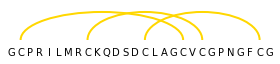

In [5]:
# Create a sequence object for each residue in the structure
# As we want each residue to appear only once in the sequence,
# we choose an atom that appears in each residue once: the CA
sequence = seq.ProteinSequence(knottin.res_name[knottin.atom_name == "CA"])
figure = plt.figure(figsize=(4.0, 1.0))
ax = figure.gca()
MARGIN = 0.2
ax.set_xlim(1-MARGIN, len(sequence)+MARGIN)
ax.set_ylim(0, 1+MARGIN)
ax.set_xticks(np.arange(1, len(sequence)+1))
ax.set_xticklabels(str(sequence))
ax.yaxis.set_tick_params(
    left=False, right=False, labelleft=False, labelright=False
)
ax.xaxis.set_tick_params(
    bottom=True, top=False, labelbottom=True, labeltop=False, width=0
)
ax.set_frame_on(False)
for sg1_index, sg2_index in disulfide_bonds:
    sg1_res_id = knottin.res_id[sg1_index]
    sg2_res_id = knottin.res_id[sg2_index]
    ellipse_center = (sg1_res_id + sg2_res_id) / 2
    ellipse_width = sg2_res_id - sg1_res_id
    # Height is 2 instead of 1,
    # because only the upper half of the ellipse is visible
    ax.add_patch(patches.Ellipse(
        xy=(ellipse_center, 0), width=ellipse_width, height=2,
        facecolor="None", edgecolor="gold", linewidth=2
    ))
figure.tight_layout()

Finally, the detected bonds are added to the structure.
Basically, the removal step above is reversed.

